# D — Dataset generation (clean, working) — Helmholtz + outer-collar PML

This notebook generates **small datasets** of paired right-hand sides `f` and solutions `u` for your 2D Helmholtz solver, using your current project APIs.

### What this notebook guarantees
- Uses your **actual config classes**:
  - `HelmholtzConfig(omega, grid, pml, ppw_target)` and `PMLConfig(thickness, strength, power)` fileciteturn1file1
- Uses your **actual assembly API**: `assemble_helmholtz_matrix(cfg, c)` fileciteturn1file4
- Uses your **actual grid extension** API: `grid_from_ppw_with_pml_extension(...)` fileciteturn1file3
- Medium built via `build_medium(cfg, case, X, Y)` fileciteturn1file2
- PML profiles are built internally by the assembler when `cfg.pml` is enabled. fileciteturn1file4turn1file5

### Dataset plan implemented
- **Train 50**, **Val 5**, **Test 5** (edit in one place)
- Two modes:
  1) **1 point source**
  2) **random 1–5 point sources**
- Randomize point-source location and amplitude in **[1, 2]** (complex phase random)
- Save **physical domain only** (crop out PML collar)
- Save a **manifest JSONL** with all parameter choices + timing

---

> **Indexing convention used here (important):**  
> All fields are shaped **(nx, ny)** where `i` indexes x and `j` indexes y, matching your assembler expectations. fileciteturn1file4  
> Therefore, physical embedding uses `f_ext[si, sj] = f_phys` where `(si, sj)` are the core slices returned by the extended grid helper. fileciteturn1file3

In [ ]:

# --- Standard libs ---
from __future__ import annotations
from pathlib import Path
import time
import json
import numpy as np

# Optional progress bar
try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **kw: x

# --- Project imports ---
from core.config import HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.resolution import grid_from_ppw_with_pml_extension, extended_grid_for_pair
from operators.assemble import assemble_helmholtz_matrix

import scipy.sparse.linalg as spla

print("✅ Imports OK")

ImportError: cannot import name 'extended_grid_for_pair' from 'core.resolution' (C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\resolution.py)

: 

## 0) Settings

Edit these constants to change dataset size, frequencies, discretization, etc.

In [2]:

# -----------------------
# Output roots
# -----------------------
OUT_ROOT_1SRC = Path("data/D_outercollar_1src")
OUT_ROOT_RAND = Path("data/D_outercollar_rand1to5")
OUT_ROOT_1SRC.mkdir(parents=True, exist_ok=True)
OUT_ROOT_RAND.mkdir(parents=True, exist_ok=True)

# -----------------------
# Split sizes (start small)
# -----------------------
N_TRAIN, N_VAL, N_TEST = 50, 5, 5

# -----------------------
# Frequencies
# -----------------------
OMEGA_LIST = [32.0, 64.0, 128.0]   # extend anytime

# -----------------------
# Physical domain
# -----------------------
LX, LY = 1.0, 1.0
X_MIN, Y_MIN = 0.0, 0.0

# -----------------------
# Resolution / physics
# -----------------------
PPW = 10.0      # points per wavelength target
C_MIN = 1.0     # conservative wavespeed for grid sizing
N_MIN_PHYS = 201

# -----------------------
# Source randomization
# -----------------------
AMP_MIN, AMP_MAX = 1.0, 2.0
SOURCE_MARGIN = 0.10  # keep sources away from physical boundary (in [0,1])

# -----------------------
# PML chooser baseline (from your sweeps)
# -----------------------
NPML_REF = 40
ETA_REF  = 6.0
PML_POWER = 2.0   # fixed polynomial order 2

# PML thickness policy: target this many wavelengths inside PML
# (npml ~ n_waves * ppw)
PML_N_WAVES = 4.0

# -----------------------
# RNG
# -----------------------
SEED = 1234
rng = np.random.default_rng(SEED)

print("Settings loaded.")

Settings loaded.


## 1) Small utilities

- `choose_pml_params(...)`: computes `(npml, eta)` from `ppw` using your validated baseline as reference.
- `grid_coords_1d(...)` and `mesh_ij(...)`: build `(X, Y)` with shape `(nx, ny)` (matching assembler).
- `save_npz(...)` and JSONL logger.

In [3]:

def choose_pml_params(*, ppw: float, npml_ref: int = NPML_REF, eta_ref: float = ETA_REF,
                      n_waves: float = PML_N_WAVES,
                      npml_min: int = 10, npml_max: int = 80,
                      eta_min: float = 2.0, eta_max: float = 10.0) -> tuple[int, float]:
    """PML chooser.

    - npml is chosen as roughly n_waves * ppw (thickness in wavelengths expressed in grid points)
    - eta is scaled inversely with npml so that eta*npml stays roughly constant
      (anchored at npml_ref, eta_ref from your sweeps).
    """
    npml = int(np.clip(np.ceil(n_waves * float(ppw)), npml_min, npml_max))
    eta  = float(np.clip(float(eta_ref) * (float(npml_ref) / max(npml, 1)), eta_min, eta_max))
    return npml, eta


def grid_coords_1d(grid) -> tuple[np.ndarray, np.ndarray]:
    """Return x[i], y[j] arrays using Grid2D metadata."""
    x = float(grid.x_min) + float(grid.hx) * np.arange(int(grid.nx))
    y = float(grid.y_min) + float(grid.hy) * np.arange(int(grid.ny))
    return x, y


def mesh_ij(grid) -> tuple[np.ndarray, np.ndarray]:
    """Return X,Y with shape (nx, ny) using indexing='ij'."""
    x, y = grid_coords_1d(grid)
    X, Y = np.meshgrid(x, y, indexing="ij")
    return X, Y


def save_npz(path: Path, **arrays) -> None:
    """Save compressed .npz (creates parent dirs)."""
    path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(path, **arrays)


def append_jsonl(path: Path, row: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

## 2) RHS generation (point sources)

We inject sources by nearest grid node on the **physical grid**.
All arrays are `(nx, ny)` (x-first, y-second).

In [4]:

def random_point_sources(*, n_sources: int, amp_min: float, amp_max: float, margin: float):
    """Random sources with (x,y) in [margin,1-margin]^2 and amp in [amp_min,amp_max]."""
    xs = rng.uniform(margin, 1.0 - margin, size=n_sources)
    ys = rng.uniform(margin, 1.0 - margin, size=n_sources)
    amps = rng.uniform(amp_min, amp_max, size=n_sources)
    phases = rng.uniform(0.0, 2*np.pi, size=n_sources)

    return [
        {"x": float(x), "y": float(y), "amp": float(a), "phase": float(ph)}
        for x, y, a, ph in zip(xs, ys, amps, phases)
    ]


def build_rhs_from_sources(grid_phys, sources) -> np.ndarray:
    """Nearest-node injection on physical grid. Returns f_phys (nx, ny) complex."""
    nx, ny = int(grid_phys.nx), int(grid_phys.ny)
    x, y = grid_coords_1d(grid_phys)

    f = np.zeros((nx, ny), dtype=np.complex128)
    for s in sources:
        ix = int(np.argmin(np.abs(x - s["x"])))
        iy = int(np.argmin(np.abs(y - s["y"])))
        f[ix, iy] += s["amp"] * np.exp(1j * s["phase"])
    return f

## 3) One sample solve (extended domain, then crop to physical)

In [5]:

def solve_one_sample(*, omega: float, ppw: float, sources, case_name: str = "const"):
    # --- choose PML ---
    npml, eta = choose_pml_params(ppw=ppw)

    # --- grids ---
    ext = grid_from_ppw_with_pml_extension(
        omega=float(omega),
        ppw=float(ppw),
        lx=float(LX),
        ly=float(LY),
        npml=int(npml),
        c_min=float(C_MIN),
        n_min_phys=int(N_MIN_PHYS),
        make_odd_phys=True,
        x_min_phys=float(X_MIN),
        y_min_phys=float(Y_MIN),
    )
    gphys = ext.grid_phys
    gext  = ext.grid_ext
    si, sj = ext.core_slices  # slices in (x,y) indexing for arrays shaped (nx,ny)

    # --- configs (frozen dataclasses) ---
    pml_cfg = PMLConfig(thickness=int(npml), strength=float(eta), power=float(PML_POWER))
    cfg = HelmholtzConfig(omega=float(omega), grid=gext, pml=pml_cfg, ppw_target=float(ppw))

    # --- case + medium on extended grid ---
    cases = make_default_cases()
    if case_name not in cases:
        raise KeyError(f"Unknown case '{case_name}'. Available: {list(cases.keys())}")
    case = cases[case_name]

    X, Y = mesh_ij(gext)
    c = build_medium(cfg=cfg, case=case, X=X, Y=Y)  # (nx,ny)

    # --- assemble (PML handled internally when cfg.pml exists) ---
    A = assemble_helmholtz_matrix(cfg, c)

    # --- RHS: build on physical, embed into extended ---
    f_phys = build_rhs_from_sources(gphys, sources)  # (nxp,nyp)
    f_ext = np.zeros((gext.nx, gext.ny), dtype=np.complex128)
    f_ext[si, sj] = f_phys

    b = f_ext.reshape(-1)

    # --- solve ---
    t0 = time.perf_counter()
    u_vec = spla.spsolve(A, b)
    solve_time = time.perf_counter() - t0

    # --- reshape + crop ---
    u_ext = u_vec.reshape(gext.nx, gext.ny)
    u_phys = u_ext[si, sj].copy()

    # --- residual (relative) ---
    r = A @ u_vec - b
    res_rel = float(np.linalg.norm(r) / (np.linalg.norm(b) + 1e-30))

    meta = {
        "omega": float(omega),
        "ppw": float(ppw),
        "case": case_name,
        "pml": {"npml": int(npml), "eta": float(eta), "power": float(PML_POWER), "n_waves": float(PML_N_WAVES)},
        "grid_phys": {"nx": int(gphys.nx), "ny": int(gphys.ny), "hx": float(gphys.hx), "hy": float(gphys.hy),
                      "x_min": float(gphys.x_min), "y_min": float(gphys.y_min), "lx": float(gphys.lx), "ly": float(gphys.ly)},
        "grid_ext": {"nx": int(gext.nx), "ny": int(gext.ny), "hx": float(gext.hx), "hy": float(gext.hy),
                     "x_min": float(gext.x_min), "y_min": float(gext.y_min), "lx": float(gext.lx), "ly": float(gext.ly)},
        "solve_time_sec": float(solve_time),
        "res_rel": float(res_rel),
        "sources": sources,
    }
    return f_phys, u_phys, meta

## 4) Split generator (timed + manifest)

In [6]:

def save_sample_npz(out_path: Path, f_phys: np.ndarray, u_phys: np.ndarray, meta: dict) -> None:
    save_npz(
        out_path,
        f_real=np.real(f_phys).astype(np.float32),
        f_imag=np.imag(f_phys).astype(np.float32),
        u_real=np.real(u_phys).astype(np.float32),
        u_imag=np.imag(u_phys).astype(np.float32),
        meta_json=np.array([json.dumps(meta)], dtype=object),
    )


def generate_split(*, out_root: Path, split: str, n_samples: int, n_sources_mode: str,
                   case_name: str = "const", start_id: int = 0) -> Path:
    split_dir = out_root / split
    split_dir.mkdir(parents=True, exist_ok=True)

    manifest_path = out_root / f"manifest_{split}.jsonl"
    if manifest_path.exists():
        manifest_path.unlink()

    total_t0 = time.perf_counter()
    solve_times = []

    for i in tqdm(range(n_samples), desc=f"Generating {split}"):
        sid = start_id + i
        omega = float(rng.choice(OMEGA_LIST))

        if n_sources_mode == "one":
            ns = 1
        elif n_sources_mode == "rand_1_5":
            ns = int(rng.integers(1, 6))
        else:
            raise ValueError(f"Unknown n_sources_mode: {n_sources_mode}")

        sources = random_point_sources(n_sources=ns, amp_min=AMP_MIN, amp_max=AMP_MAX, margin=SOURCE_MARGIN)

        f_phys, u_phys, meta = solve_one_sample(omega=omega, ppw=PPW, sources=sources, case_name=case_name)

        npml = meta["pml"]["npml"]
        eta  = meta["pml"]["eta"]
        fname = f"{case_name}_sid{sid:06d}_w{int(omega)}_ppw{PPW:g}_npml{npml}_eta{eta:.3g}_ns{ns}.npz"

        out_path = split_dir / fname
        save_sample_npz(out_path, f_phys, u_phys, meta)

        row = {
            "split": split,
            "file": str(out_path.as_posix()),
            "case": case_name,
            "sample_id": int(sid),
            "omega": float(omega),
            "ppw": float(PPW),
            "nsources": int(ns),
            "npml": int(npml),
            "eta": float(eta),
            "power": float(PML_POWER),
            "solve_time_sec": float(meta["solve_time_sec"]),
            "res_rel": float(meta["res_rel"]),
            "nx_phys": int(meta["grid_phys"]["nx"]),
            "ny_phys": int(meta["grid_phys"]["ny"]),
        }
        append_jsonl(manifest_path, row)

        solve_times.append(meta["solve_time_sec"])
        if (i + 1) % max(1, n_samples // 5) == 0:
            avg_t = float(np.mean(solve_times))
            tot_t = time.perf_counter() - total_t0
            print(f"  [{split}] {i+1:4d}/{n_samples} | avg solve {avg_t:.3f}s | total {tot_t:.1f}s")

    total_time = time.perf_counter() - total_t0
    print(f"✅ Done {split}: {n_samples} samples in {total_time:.1f}s (avg solve {np.mean(solve_times):.3f}s)")
    return manifest_path

# 5A) Generate dataset — **1 source**

In [7]:

# Clean old outputs (optional)
for split in ["train", "val", "test"]:
    d = OUT_ROOT_1SRC / split
    if d.exists():
        for p in d.glob("*.npz"):
            p.unlink()

CASE_NAME = "const"

print("Generating 1-source dataset...")
m_train = generate_split(out_root=OUT_ROOT_1SRC, split="train", n_samples=N_TRAIN, n_sources_mode="one", case_name=CASE_NAME, start_id=0)
m_val   = generate_split(out_root=OUT_ROOT_1SRC, split="val",   n_samples=N_VAL,   n_sources_mode="one", case_name=CASE_NAME, start_id=N_TRAIN)
m_test  = generate_split(out_root=OUT_ROOT_1SRC, split="test",  n_samples=N_TEST,  n_sources_mode="one", case_name=CASE_NAME, start_id=N_TRAIN+N_VAL)

print("Manifests:")
print(" -", m_train)
print(" -", m_val)
print(" -", m_test)

Generating 1-source dataset...


Generating train:  20%|██        | 10/50 [01:15<05:29,  8.24s/it]

  [train]   10/50 | avg solve 7.132s | total 75.8s


Generating train:  40%|████      | 20/50 [02:50<04:37,  9.25s/it]

  [train]   20/50 | avg solve 8.059s | total 170.8s


Generating train:  60%|██████    | 30/50 [04:21<02:59,  9.00s/it]

  [train]   30/50 | avg solve 8.240s | total 261.7s


Generating train:  80%|████████  | 40/50 [05:52<01:31,  9.13s/it]

  [train]   40/50 | avg solve 8.335s | total 352.8s


Generating train: 100%|██████████| 50/50 [07:22<00:00,  8.86s/it]


  [train]   50/50 | avg solve 8.375s | total 442.8s
✅ Done train: 50 samples in 442.8s (avg solve 8.375s)


Generating val:  20%|██        | 1/5 [00:08<00:35,  8.93s/it]

  [val]    1/5 | avg solve 8.508s | total 8.9s


Generating val:  40%|████      | 2/5 [00:17<00:26,  8.89s/it]

  [val]    2/5 | avg solve 8.463s | total 17.8s


Generating val:  60%|██████    | 3/5 [00:26<00:17,  8.84s/it]

  [val]    3/5 | avg solve 8.412s | total 26.6s


Generating val:  80%|████████  | 4/5 [00:35<00:08,  8.82s/it]

  [val]    4/5 | avg solve 8.399s | total 35.4s


Generating val: 100%|██████████| 5/5 [00:44<00:00,  8.90s/it]


  [val]    5/5 | avg solve 8.463s | total 44.5s
✅ Done val: 5 samples in 44.5s (avg solve 8.463s)


Generating test:  20%|██        | 1/5 [00:09<00:37,  9.31s/it]

  [test]    1/5 | avg solve 8.862s | total 9.3s


Generating test:  40%|████      | 2/5 [00:18<00:28,  9.50s/it]

  [test]    2/5 | avg solve 9.000s | total 18.9s


Generating test:  60%|██████    | 3/5 [00:27<00:18,  9.19s/it]

  [test]    3/5 | avg solve 8.798s | total 27.8s


Generating test:  80%|████████  | 4/5 [00:36<00:09,  9.12s/it]

  [test]    4/5 | avg solve 8.741s | total 36.8s


Generating test: 100%|██████████| 5/5 [00:45<00:00,  9.14s/it]

  [test]    5/5 | avg solve 8.694s | total 45.7s
✅ Done test: 5 samples in 45.7s (avg solve 8.694s)
Manifests:
 - data\D_outercollar_1src\manifest_train.jsonl
 - data\D_outercollar_1src\manifest_val.jsonl
 - data\D_outercollar_1src\manifest_test.jsonl


In [8]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

ROOT = OUT_ROOT_1SRC  # from notebook
splits = ["train", "val", "test"]

def load_manifest(split):
    p = ROOT / f"manifest_{split}.jsonl"
    rows = []
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return rows

man = {s: load_manifest(s) for s in splits}
for s in splits:
    print(s, "N=", len(man[s]))

# quick distributions
def summarize(rows, key):
    v = np.array([r[key] for r in rows], dtype=float)
    return dict(min=float(v.min()), p50=float(np.median(v)), p90=float(np.quantile(v,0.9)), max=float(v.max()))

print("solve_time_sec train:", summarize(man["train"], "solve_time_sec"))
print("res_rel        train:", summarize(man["train"], "res_rel"))
print("omega counts   train:", {w: sum(r["omega"]==w for r in man["train"]) for w in sorted(set(r["omega"] for r in man["train"]))})
print("npml unique    train:", sorted(set(r["npml"] for r in man["train"])))
print("eta  unique    train:", sorted(set(round(r["eta"],6) for r in man["train"]))[:10], "...")


train N= 50
val N= 5
test N= 5
solve_time_sec train: {'min': 6.535235599963926, 'p50': 8.54258295003092, 'p90': 9.14046062998823, 'max': 9.43738180003129}
res_rel        train: {'min': 1.6574413593634006e-14, 'p50': 3.5371129352407476e-14, 'p90': 8.785775102385352e-14, 'max': 1.0946056566365269e-13}
omega counts   train: {32.0: 12, 64.0: 15, 128.0: 23}
npml unique    train: [40]
eta  unique    train: [6.0] ...


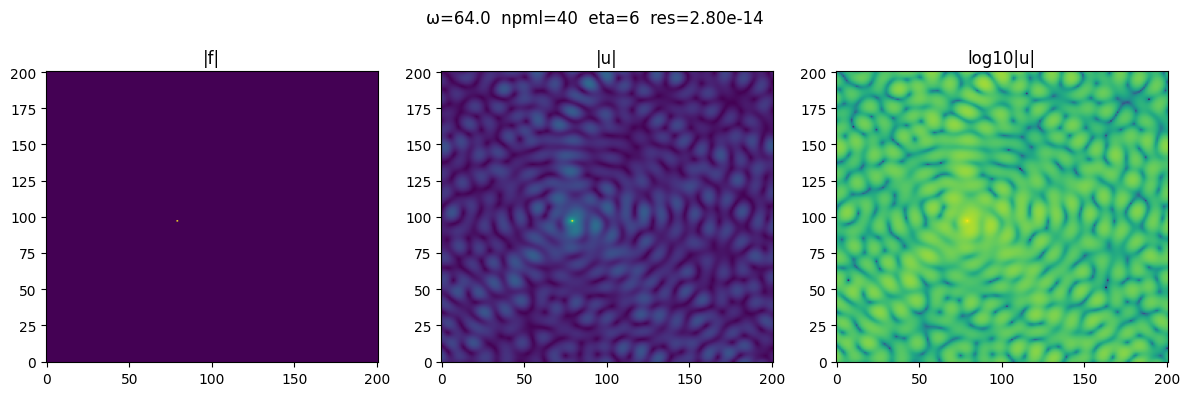

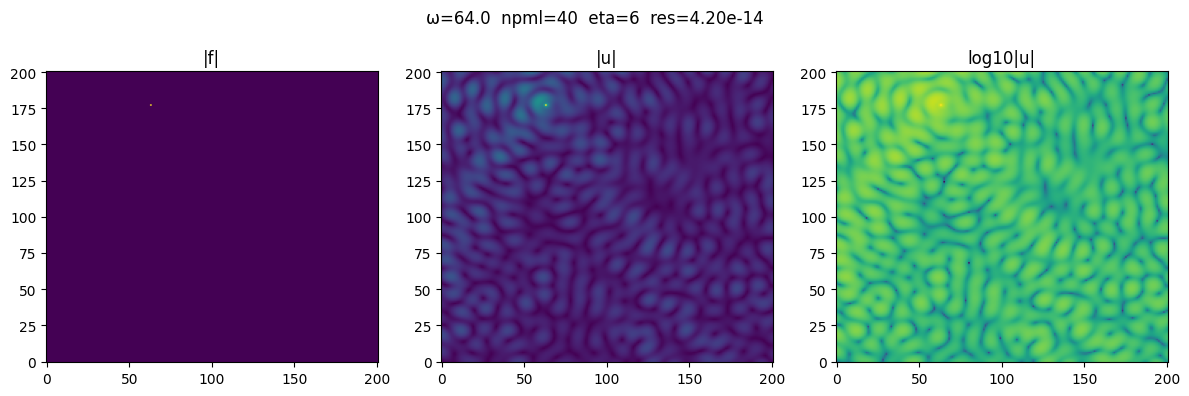

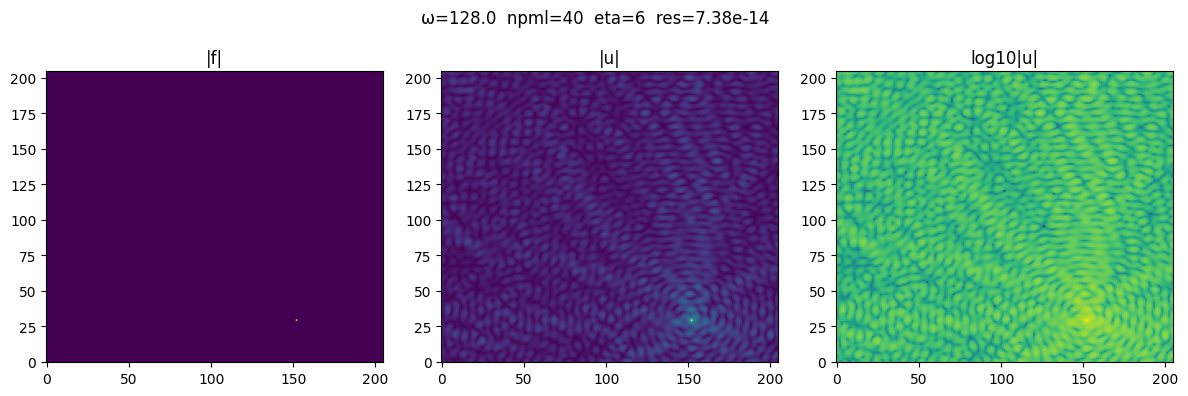

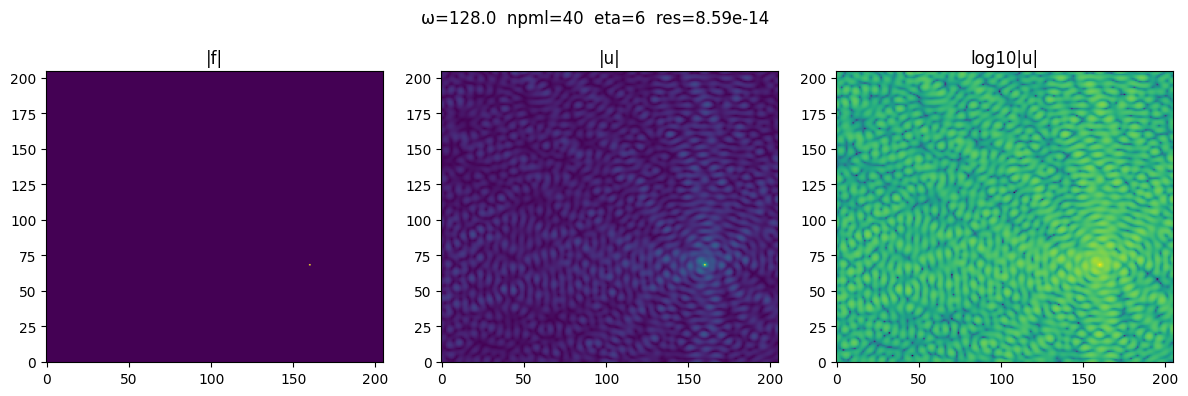

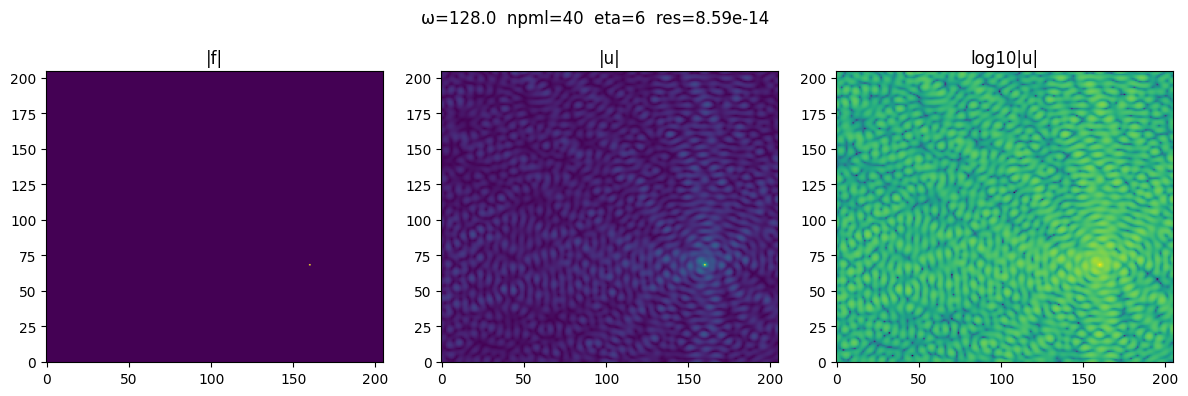

In [9]:
import random, json, numpy as np, matplotlib.pyplot as plt

def load_npz(path):
    z = np.load(path, allow_pickle=True)
    f = z["f_real"] + 1j*z["f_imag"]
    u = z["u_real"] + 1j*z["u_imag"]
    meta = json.loads(str(z["meta_json"][0]))
    return f, u, meta

def show_sample(path):
    f, u, meta = load_npz(path)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(np.abs(f).T, origin="lower", aspect="auto")
    axs[0].set_title("|f|")
    axs[1].imshow(np.abs(u).T, origin="lower", aspect="auto")
    axs[1].set_title("|u|")
    axs[2].imshow(np.log10(np.abs(u).T + 1e-16), origin="lower", aspect="auto")
    axs[2].set_title("log10|u|")
    fig.suptitle(f"ω={meta['omega']}  npml={meta['pml']['npml']}  eta={meta['pml']['eta']:.3g}  res={meta['res_rel']:.2e}")
    plt.tight_layout()
    plt.show()

train_files = sorted((ROOT / "train").glob("*.npz"))
for _ in range(5):
    show_sample(random.choice(train_files))


In [10]:
def boundary_ratio(u, band=8):
    A = np.abs(u)
    nx, ny = A.shape
    b = band
    interior = A[b:-b, b:-b]
    mask = np.zeros_like(A, dtype=bool)
    mask[:b,:]=True; mask[-b:,:]=True; mask[:,:b]=True; mask[:,-b:]=True
    boundary = A[mask]
    return float(boundary.mean() / (interior.mean() + 1e-30)), float(boundary.max() / (interior.max() + 1e-30))

ratios = []
for p in train_files[:30]:  # quick
    _, u, meta = load_npz(p)
    r_mean, r_max = boundary_ratio(u, band=8)
    ratios.append((meta["omega"], r_mean, r_max, meta["res_rel"]))

# print summary by omega
for w in sorted(set(x[0] for x in ratios)):
    rr = np.array([[r[1], r[2]] for r in ratios if r[0]==w])
    print(f"ω={w:>5.1f}  boundary/interior mean: median={np.median(rr[:,0]):.3g}, p90={np.quantile(rr[:,0],0.9):.3g} | max-ratio median={np.median(rr[:,1]):.3g}")


ω= 32.0  boundary/interior mean: median=0.937, p90=1.02 | max-ratio median=0.326
ω= 64.0  boundary/interior mean: median=0.937, p90=1.03 | max-ratio median=0.287
ω=128.0  boundary/interior mean: median=0.877, p90=0.919 | max-ratio median=0.245


In [11]:
def norms(u):
    A = np.abs(u)
    return float(np.linalg.norm(A)), float(A.max()), float(A.mean())

stats=[]
for p in train_files[:50]:
    _, u, meta = load_npz(p)
    n2, mx, mean = norms(u)
    stats.append((meta["omega"], n2, mx, mean))

stats=np.array(stats, dtype=float)
print("||u||2  min/med/max:", stats[:,1].min(), np.median(stats[:,1]), stats[:,1].max())
print("max|u| min/med/max:", stats[:,2].min(), np.median(stats[:,2]), stats[:,2].max())
print("mean|u|min/med/max:", stats[:,3].min(), np.median(stats[:,3]), stats[:,3].max())


||u||2  min/med/max: 0.00023193661763798445 0.00042397108336444944 0.0010692763607949018
max|u| min/med/max: 1.0974727047141641e-05 1.9409108972467948e-05 2.9820961572113447e-05
mean|u|min/med/max: 9.86539589575841e-07 1.8241836983179383e-06 4.69443421025062e-06


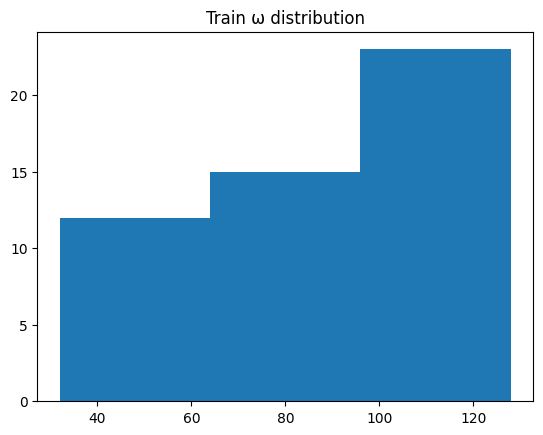

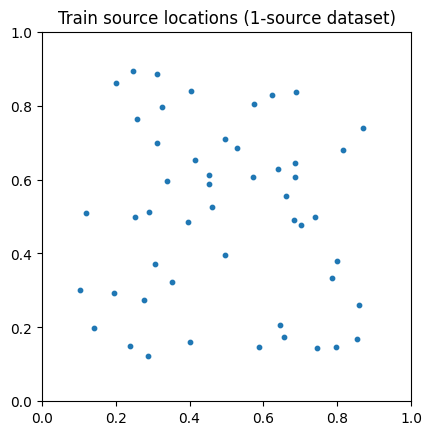

In [12]:
rows = man["train"]
omegas = [r["omega"] for r in rows]
plt.figure()
plt.hist(omegas, bins=len(set(omegas)))
plt.title("Train ω distribution")
plt.show()

# Source locations from meta in npz (more reliable)
xs, ys = [], []
for p in train_files[:200]:
    _, _, meta = load_npz(p)
    s = meta["sources"][0]
    xs.append(s["x"]); ys.append(s["y"])
plt.figure()
plt.scatter(xs, ys, s=10)
plt.xlim(0,1); plt.ylim(0,1)
plt.title("Train source locations (1-source dataset)")
plt.gca().set_aspect("equal", "box")
plt.show()


Showing sample: const_sid000000_w128_ppw10_npml40_eta6_ns1.npz
Metadata:
  omega: 128.0
  res_rel: 7.615237108627063e-14


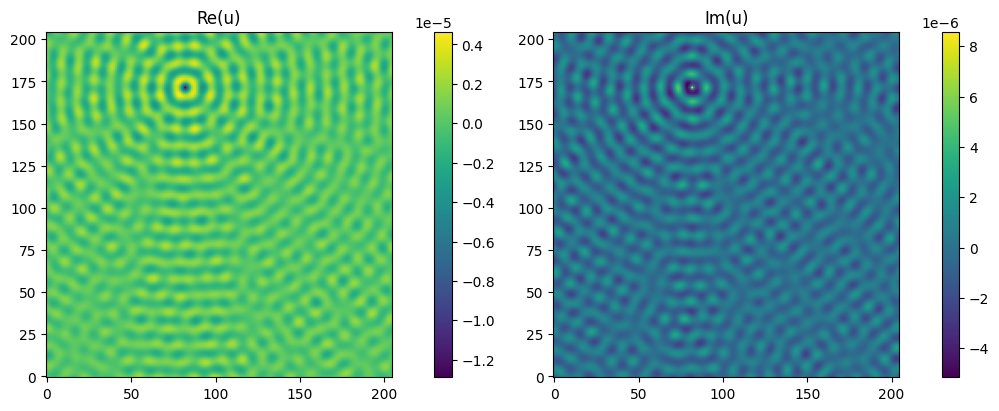

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ---- point to your 5A dataset ----
DATA_DIR = Path("data/D_outercollar_1src/train")

# pick one sample file
sample_path = sorted(DATA_DIR.glob("*.npz"))[0]
print("Showing sample:", sample_path.name)

# load data
data = np.load(sample_path, allow_pickle=True)

u_real = data["u_real"]
u_imag = data["u_imag"]
meta = json.loads(data["meta_json"][0])

print("Metadata:")
for k, v in meta.items():
    if k in ("omega", "npml", "eta", "m", "res_rel"):
        print(f"  {k}: {v}")

# ---- plot Re(u) and Im(u) ----
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axs[0].imshow(u_real.T, origin="lower")
axs[0].set_title("Re(u)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(u_imag.T, origin="lower")
axs[1].set_title("Im(u)")
plt.colorbar(im1, ax=axs[1])

plt.show()


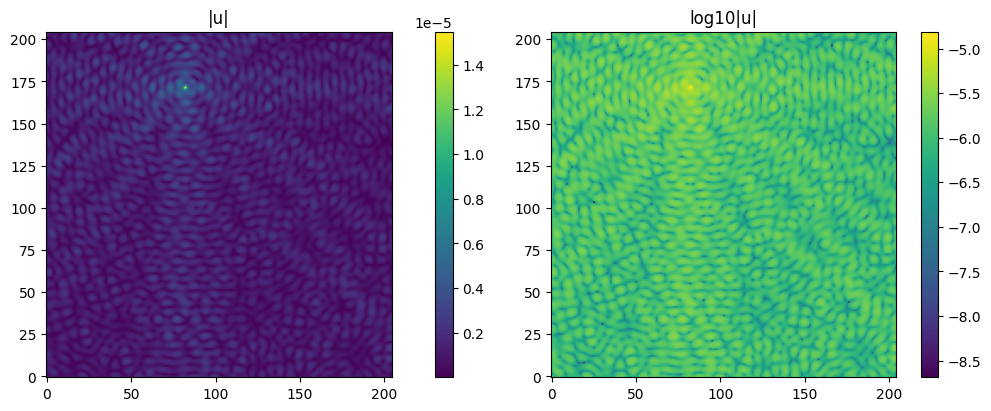

In [16]:
u = u_real + 1j*u_imag
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
im0 = axs[0].imshow(np.abs(u).T, origin="lower"); axs[0].set_title("|u|"); plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(np.log10(np.abs(u).T + 1e-16), origin="lower"); axs[1].set_title("log10|u|"); plt.colorbar(im1, ax=axs[1])
plt.show()


# 5B) Generate dataset — **random 1–5 sources**

In [17]:

# Clean old outputs (optional)
for split in ["train", "val", "test"]:
    d = OUT_ROOT_RAND / split
    if d.exists():
        for p in d.glob("*.npz"):
            p.unlink()

CASE_NAME = "const"

print("Generating random 1–5 source dataset...")
m_train = generate_split(out_root=OUT_ROOT_RAND, split="train", n_samples=N_TRAIN, n_sources_mode="rand_1_5", case_name=CASE_NAME, start_id=0)
m_val   = generate_split(out_root=OUT_ROOT_RAND, split="val",   n_samples=N_VAL,   n_sources_mode="rand_1_5", case_name=CASE_NAME, start_id=N_TRAIN)
m_test  = generate_split(out_root=OUT_ROOT_RAND, split="test",  n_samples=N_TEST,  n_sources_mode="rand_1_5", case_name=CASE_NAME, start_id=N_TRAIN+N_VAL)

print("Manifests:")
print(" -", m_train)
print(" -", m_val)
print(" -", m_test)

Generating random 1–5 source dataset...


Generating train:  20%|██        | 10/50 [01:15<04:58,  7.46s/it]

  [train]   10/50 | avg solve 7.125s | total 75.8s


Generating train:  40%|████      | 20/50 [02:29<03:37,  7.25s/it]

  [train]   20/50 | avg solve 7.007s | total 149.1s


Generating train:  60%|██████    | 30/50 [04:07<03:24, 10.24s/it]

  [train]   30/50 | avg solve 7.785s | total 247.6s


Generating train:  80%|████████  | 40/50 [05:40<01:29,  8.99s/it]

  [train]   40/50 | avg solve 8.034s | total 340.5s


Generating train: 100%|██████████| 50/50 [07:09<00:00,  8.59s/it]


  [train]   50/50 | avg solve 8.121s | total 429.7s
✅ Done train: 50 samples in 429.7s (avg solve 8.121s)


Generating val:  20%|██        | 1/5 [00:09<00:36,  9.08s/it]

  [val]    1/5 | avg solve 8.553s | total 9.1s


Generating val:  40%|████      | 2/5 [00:18<00:26,  8.99s/it]

  [val]    2/5 | avg solve 8.521s | total 18.0s


Generating val:  60%|██████    | 3/5 [00:26<00:17,  8.96s/it]

  [val]    3/5 | avg solve 8.500s | total 26.9s


Generating val:  80%|████████  | 4/5 [00:35<00:08,  8.92s/it]

  [val]    4/5 | avg solve 8.477s | total 35.8s


Generating val: 100%|██████████| 5/5 [00:44<00:00,  8.93s/it]


  [val]    5/5 | avg solve 8.455s | total 44.7s
✅ Done val: 5 samples in 44.7s (avg solve 8.455s)


Generating test:  20%|██        | 1/5 [00:09<00:36,  9.06s/it]

  [test]    1/5 | avg solve 8.556s | total 9.1s


Generating test:  40%|████      | 2/5 [00:17<00:26,  8.99s/it]

  [test]    2/5 | avg solve 8.526s | total 18.0s


Generating test:  60%|██████    | 3/5 [00:26<00:17,  8.93s/it]

  [test]    3/5 | avg solve 8.470s | total 26.9s


Generating test:  80%|████████  | 4/5 [00:36<00:09,  9.03s/it]

  [test]    4/5 | avg solve 8.538s | total 36.0s


Generating test: 100%|██████████| 5/5 [00:45<00:00,  9.00s/it]

  [test]    5/5 | avg solve 8.539s | total 45.0s
✅ Done test: 5 samples in 45.0s (avg solve 8.539s)
Manifests:
 - data\D_outercollar_rand1to5\manifest_train.jsonl
 - data\D_outercollar_rand1to5\manifest_val.jsonl
 - data\D_outercollar_rand1to5\manifest_test.jsonl


## 6) Quick sanity check: load one sample

In [18]:

import json as _json

sample_files = sorted((OUT_ROOT_1SRC / "train").glob("*.npz"))
assert sample_files, "No samples found. Run section 5A first."

p = sample_files[0]
z = np.load(p, allow_pickle=True)
meta = _json.loads(str(z["meta_json"][0]))

print("File:", p)
print("Keys:", list(z.keys()))
print("f shape:", z["f_real"].shape, "u shape:", z["u_real"].shape)
print("omega:", meta["omega"], "ppw:", meta["ppw"], "nsources:", len(meta["sources"]))
print("PML:", meta["pml"])
print("solve_time_sec:", meta["solve_time_sec"], "res_rel:", meta["res_rel"])

File: data\D_outercollar_1src\train\const_sid000000_w128_ppw10_npml40_eta6_ns1.npz
Keys: ['f_real', 'f_imag', 'u_real', 'u_imag', 'meta_json']
f shape: (205, 205) u shape: (205, 205)
omega: 128.0 ppw: 10.0 nsources: 1
PML: {'npml': 40, 'eta': 6.0, 'power': 2.0, 'n_waves': 4.0}
solve_time_sec: 6.934238500020001 res_rel: 7.615237108627063e-14


In [24]:
# ============================
# 5B — full multi-source dataset
# ============================

# dataset sizes
N_TRAIN = 200
N_VAL   = 20
N_TEST  = 20

CASE_NAME = "const"
DATASET_TAG = "D_outercollar_rand1to5_200_20_20"
OUT_ROOT = Path(f"data/{DATASET_TAG}")

print(f"Writing dataset to: {OUT_ROOT.resolve()}")

# clean old files (optional safety)
for split in ("train", "val", "test"):
    d = OUT_ROOT / split
    if d.exists():
        for p in d.glob("*.npz"):
            p.unlink()

print("Generating multi-source dataset (1–5 sources per sample)...")

m_train = generate_split(
    out_root=OUT_ROOT,
    split="train",
    n_samples=N_TRAIN,
    n_sources_mode="rand_1_5",   # ✅ correct mode name
    case_name=CASE_NAME,
    start_id=0,
)

m_val = generate_split(
    out_root=OUT_ROOT,
    split="val",
    n_samples=N_VAL,
    n_sources_mode="rand_1_5",
    case_name=CASE_NAME,
    start_id=N_TRAIN,
)

m_test = generate_split(
    out_root=OUT_ROOT,
    split="test",
    n_samples=N_TEST,
    n_sources_mode="rand_1_5",
    case_name=CASE_NAME,
    start_id=N_TRAIN + N_VAL,
)

print("✅ 5B full dataset complete")
print("Manifests:")
print(" -", OUT_ROOT / "manifest_train.jsonl")
print(" -", OUT_ROOT / "manifest_val.jsonl")
print(" -", OUT_ROOT / "manifest_test.jsonl")


Writing dataset to: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\experiments\data\D_outercollar_rand1to5_200_20_20
Generating multi-source dataset (1–5 sources per sample)...


Generating train:  20%|██        | 40/200 [06:41<27:34, 10.34s/it]

  [train]   40/200 | avg solve 9.502s | total 401.3s


Generating train:  40%|████      | 80/200 [13:48<21:06, 10.55s/it]

  [train]   80/200 | avg solve 9.812s | total 828.3s


Generating train:  60%|██████    | 120/200 [21:20<13:33, 10.16s/it]

  [train]  120/200 | avg solve 10.092s | total 1280.1s


Generating train:  80%|████████  | 160/200 [28:24<06:48, 10.22s/it]

  [train]  160/200 | avg solve 10.088s | total 1704.0s


Generating train: 100%|██████████| 200/200 [35:21<00:00, 10.61s/it]


  [train]  200/200 | avg solve 10.047s | total 2121.4s
✅ Done train: 200 samples in 2121.4s (avg solve 10.047s)


Generating val:  20%|██        | 4/20 [00:45<03:03, 11.48s/it]

  [val]    4/20 | avg solve 10.813s | total 45.5s


Generating val:  40%|████      | 8/20 [01:32<02:19, 11.60s/it]

  [val]    8/20 | avg solve 10.917s | total 92.2s


Generating val:  60%|██████    | 12/20 [02:14<01:26, 10.75s/it]

  [val]   12/20 | avg solve 10.629s | total 134.5s


Generating val:  80%|████████  | 16/20 [02:56<00:42, 10.52s/it]

  [val]   16/20 | avg solve 10.453s | total 176.3s


Generating val: 100%|██████████| 20/20 [03:37<00:00, 10.88s/it]


  [val]   20/20 | avg solve 10.321s | total 217.6s
✅ Done val: 20 samples in 217.6s (avg solve 10.321s)


Generating test:  20%|██        | 4/20 [00:38<02:37,  9.87s/it]

  [test]    4/20 | avg solve 9.224s | total 38.8s


Generating test:  40%|████      | 8/20 [01:12<01:43,  8.59s/it]

  [test]    8/20 | avg solve 8.504s | total 72.1s


Generating test:  60%|██████    | 12/20 [01:57<01:27, 10.91s/it]

  [test]   12/20 | avg solve 9.224s | total 117.5s


Generating test:  80%|████████  | 16/20 [02:41<00:44, 11.06s/it]

  [test]   16/20 | avg solve 9.558s | total 161.9s


Generating test: 100%|██████████| 20/20 [03:26<00:00, 10.30s/it]

  [test]   20/20 | avg solve 9.698s | total 206.1s
✅ Done test: 20 samples in 206.1s (avg solve 9.698s)
✅ 5B full dataset complete
Manifests:
 - data\D_outercollar_rand1to5_200_20_20\manifest_train.jsonl
 - data\D_outercollar_rand1to5_200_20_20\manifest_val.jsonl
 - data\D_outercollar_rand1to5_200_20_20\manifest_test.jsonl


## Check 1 — Manifest + file integrity + metadata sanity

This verifies:

the manifest points to real files

each file has the expected keys/shapes

ω values are the intended set

nsources is 1–5

residuals are small

In [25]:
import json, numpy as np
from pathlib import Path
from collections import Counter

OUT_ROOT = Path("data/D_outercollar_rand1to5_200_20_20")

def load_manifest(manifest_path: Path):
    rows = []
    with manifest_path.open("r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return rows

def sanity_manifest(split: str, n_show: int = 3):
    manifest = OUT_ROOT / f"manifest_{split}.jsonl"
    rows = load_manifest(manifest)
    print(f"[{split}] manifest rows:", len(rows))
    assert len(rows) > 0

    omegas = []
    nsources = []
    res = []
    times = []
    shapes = set()

    # sample a few files for deeper inspection
    for i, row in enumerate(rows[:min(len(rows), 25)]):
        fp = Path(row["file"])
        assert fp.exists(), f"Missing file: {fp}"
        z = np.load(fp, allow_pickle=True)

        # keys
        for k in ["f_real","f_imag","u_real","u_imag","meta_json"]:
            assert k in z, f"Missing key {k} in {fp.name}"

        f = z["f_real"] + 1j*z["f_imag"]
        u = z["u_real"] + 1j*z["u_imag"]
        shapes.add((f.shape, u.shape))
        assert f.shape == u.shape, "f/u shape mismatch"

        meta = json.loads(z["meta_json"][0])
        omegas.append(float(meta["omega"]))
        nsources.append(len(meta["sources"]))
        res.append(float(meta["res_rel"]))
        times.append(float(meta["solve_time_sec"]))

    print("  unique shapes seen (from first 25):", shapes)
    print("  omega counts (first 25):", Counter(omegas))
    print("  nsources counts (first 25):", Counter(nsources))
    print("  res_rel stats (first 25): min/med/max",
          float(np.min(res)), float(np.median(res)), float(np.max(res)))
    print("  solve_time_sec stats (first 25): min/med/max",
          float(np.min(times)), float(np.median(times)), float(np.max(times)))

    # show a couple file names
    print("  sample files:")
    for row in rows[:n_show]:
        print("   -", Path(row["file"]).name)

sanity_manifest("train")
sanity_manifest("val")
sanity_manifest("test")


[train] manifest rows: 200
  unique shapes seen (from first 25): {((201, 201), (201, 201)), ((205, 205), (205, 205))}
  omega counts (first 25): Counter({128.0: 13, 64.0: 7, 32.0: 5})
  nsources counts (first 25): Counter({5: 7, 2: 6, 1: 6, 4: 5, 3: 1})
  res_rel stats (first 25): min/med/max 2.1336586023158157e-14 6.413528570260508e-14 9.40148527667813e-14
  solve_time_sec stats (first 25): min/med/max 7.48827380000148 9.536487900011707 10.119736900029238
  sample files:
   - const_sid000000_w128_ppw10_npml40_eta6_ns5.npz
   - const_sid000001_w64_ppw10_npml40_eta6_ns4.npz
   - const_sid000002_w128_ppw10_npml40_eta6_ns5.npz
[val] manifest rows: 20
  unique shapes seen (from first 25): {((201, 201), (201, 201)), ((205, 205), (205, 205))}
  omega counts (first 25): Counter({128.0: 8, 64.0: 7, 32.0: 5})
  nsources counts (first 25): Counter({1: 7, 2: 4, 4: 4, 3: 3, 5: 2})
  res_rel stats (first 25): min/med/max 1.9616783665069556e-14 3.8765423969172993e-14 1.1909708345381226e-13
  solve_t

## Check 2 — Visualize RHS and solution for 1–5 sources

This verifies:

RHS contains multiple point injections

solution looks like a superposition of waves

nothing “crazy” on boundaries

Picked samples:
  ns=1 -> const_sid000007_w64_ppw10_npml40_eta6_ns1.npz
  ns=2 -> const_sid000004_w64_ppw10_npml40_eta6_ns2.npz
  ns=3 -> const_sid000019_w32_ppw10_npml40_eta6_ns3.npz
  ns=4 -> const_sid000001_w64_ppw10_npml40_eta6_ns4.npz
  ns=5 -> const_sid000000_w128_ppw10_npml40_eta6_ns5.npz


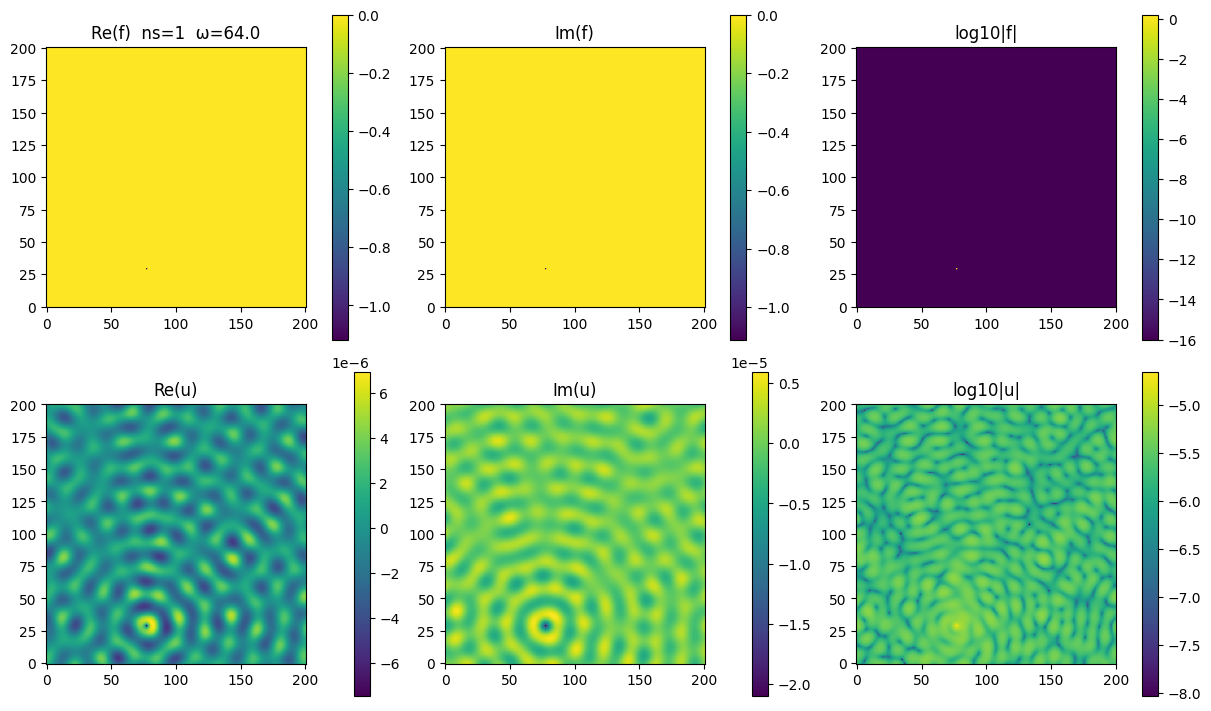

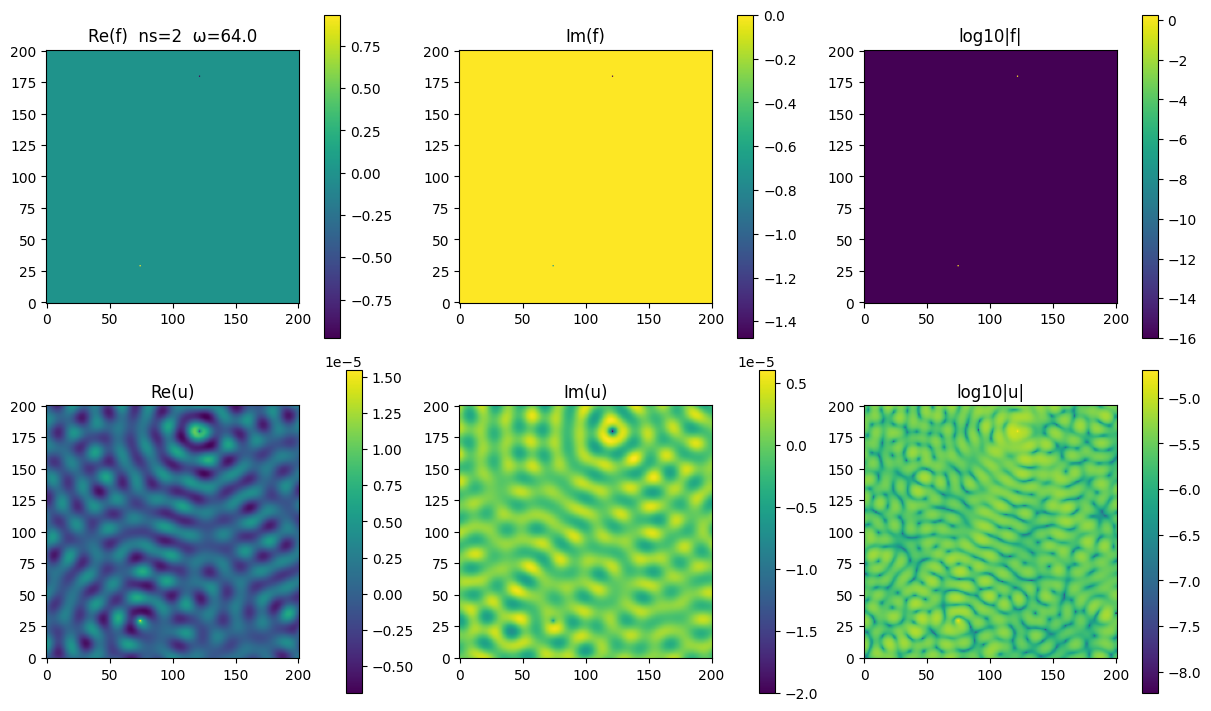

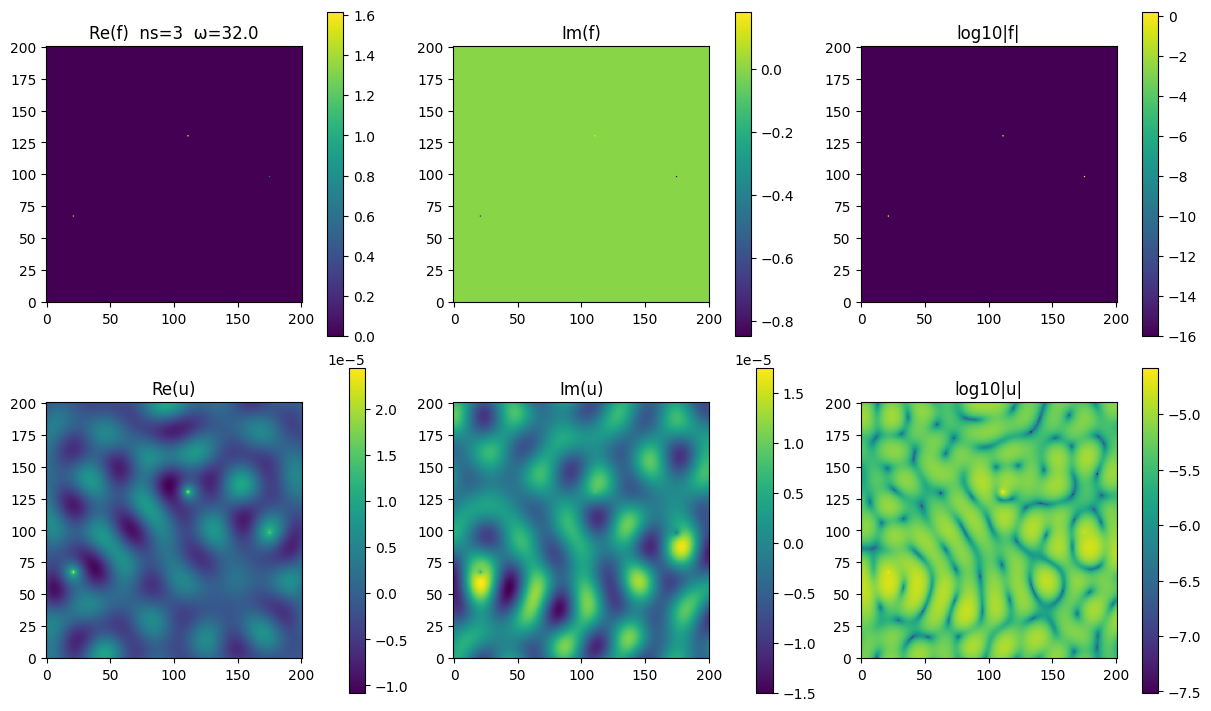

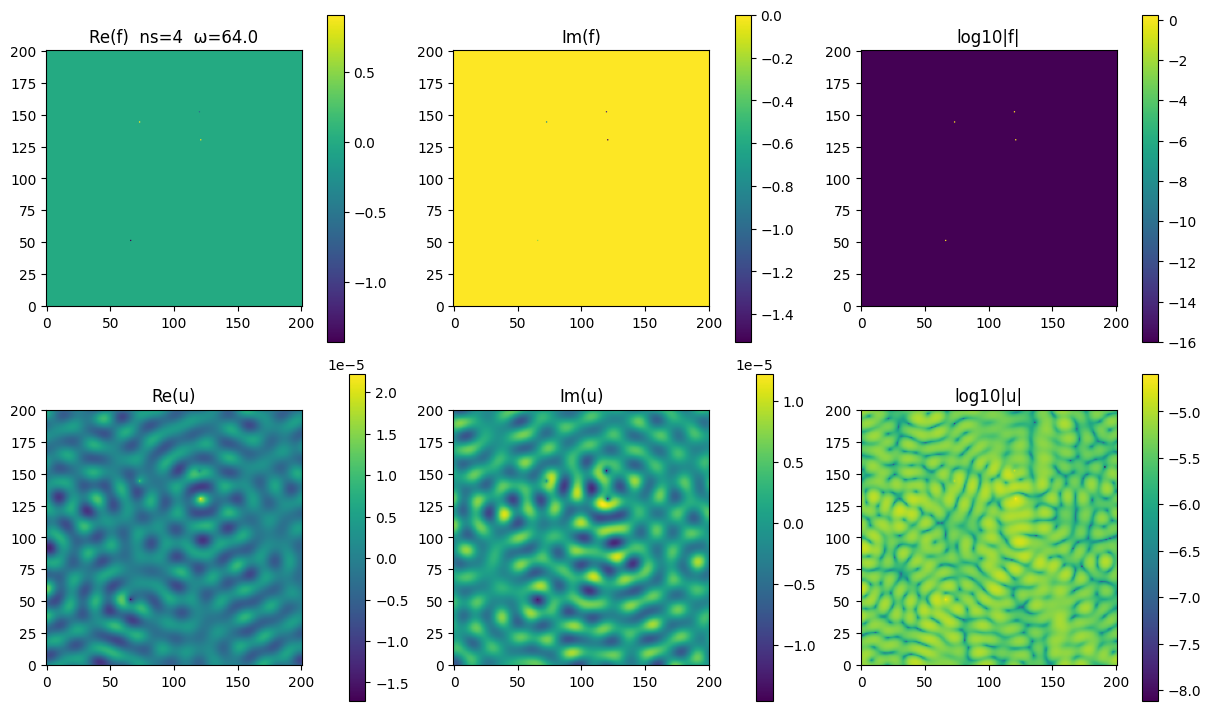

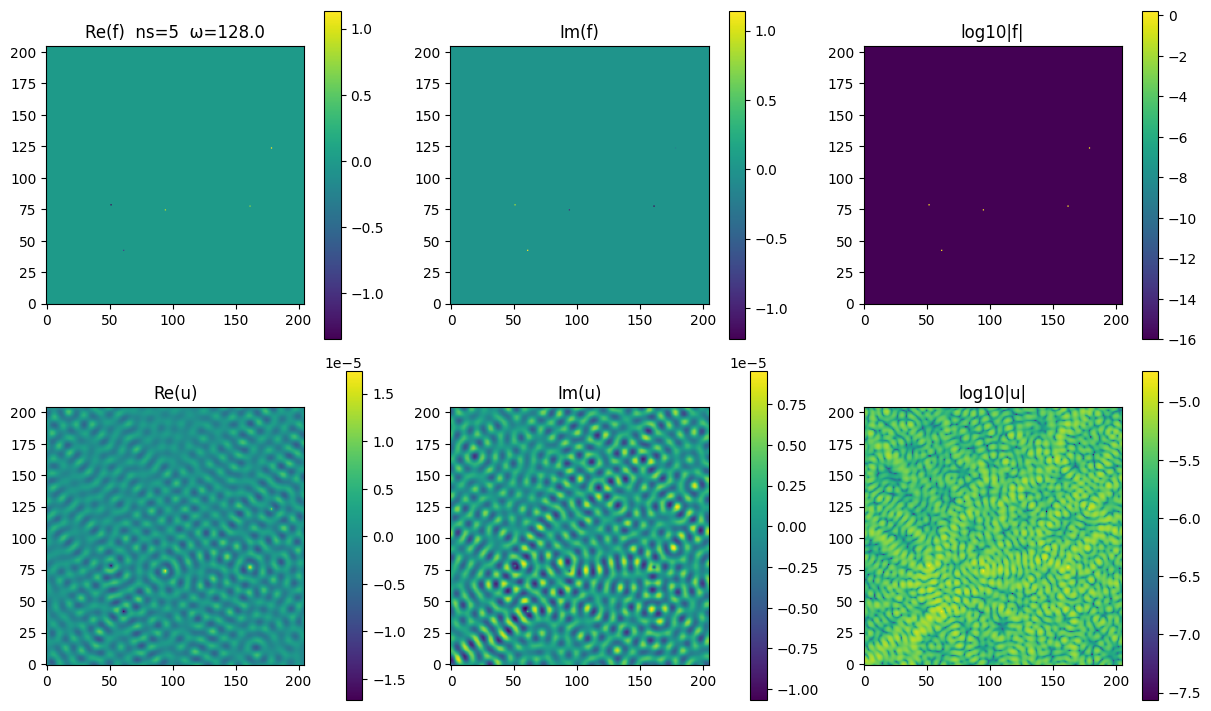

In [26]:
import numpy as np, json
import matplotlib.pyplot as plt
from pathlib import Path

OUT_ROOT = Path("data/D_outercollar_rand1to5_200_20_20")
TRAIN_DIR = OUT_ROOT / "train"

# pick one example for each nsources=1..5 (best effort)
files = sorted(TRAIN_DIR.glob("*.npz"))

picked = {}
for fp in files:
    z = np.load(fp, allow_pickle=True)
    meta = json.loads(z["meta_json"][0])
    ns = len(meta["sources"])
    if 1 <= ns <= 5 and ns not in picked:
        picked[ns] = fp
    if len(picked) == 5:
        break

print("Picked samples:")
for ns in sorted(picked):
    print(f"  ns={ns} -> {picked[ns].name}")

def show_sample(fp: Path):
    z = np.load(fp, allow_pickle=True)
    f = z["f_real"] + 1j*z["f_imag"]
    u = z["u_real"] + 1j*z["u_imag"]
    meta = json.loads(z["meta_json"][0])
    ns = len(meta["sources"])
    omega = meta["omega"]

    fig, axs = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

    # RHS: real/imag
    im = axs[0,0].imshow(np.real(f).T, origin="lower"); axs[0,0].set_title(f"Re(f)  ns={ns}  ω={omega}")
    plt.colorbar(im, ax=axs[0,0])
    im = axs[0,1].imshow(np.imag(f).T, origin="lower"); axs[0,1].set_title("Im(f)")
    plt.colorbar(im, ax=axs[0,1])
    im = axs[0,2].imshow(np.log10(np.abs(f).T + 1e-16), origin="lower"); axs[0,2].set_title("log10|f|")
    plt.colorbar(im, ax=axs[0,2])

    # Solution: real/imag/log|u|
    im = axs[1,0].imshow(np.real(u).T, origin="lower"); axs[1,0].set_title("Re(u)")
    plt.colorbar(im, ax=axs[1,0])
    im = axs[1,1].imshow(np.imag(u).T, origin="lower"); axs[1,1].set_title("Im(u)")
    plt.colorbar(im, ax=axs[1,1])
    im = axs[1,2].imshow(np.log10(np.abs(u).T + 1e-16), origin="lower"); axs[1,2].set_title("log10|u|")
    plt.colorbar(im, ax=axs[1,2])

    plt.show()

for ns in sorted(picked):
    show_sample(picked[ns])


## Check 3 — Linearity/superposition check using a dataset sample

This checks the most important thing for multi-source correctness:

does the multi-source solution equal the sum of single-source solutions?

Testing superposition on: const_sid000000_w128_ppw10_npml40_eta6_ns5.npz
Relative superposition error: 2.527532459066137e-08


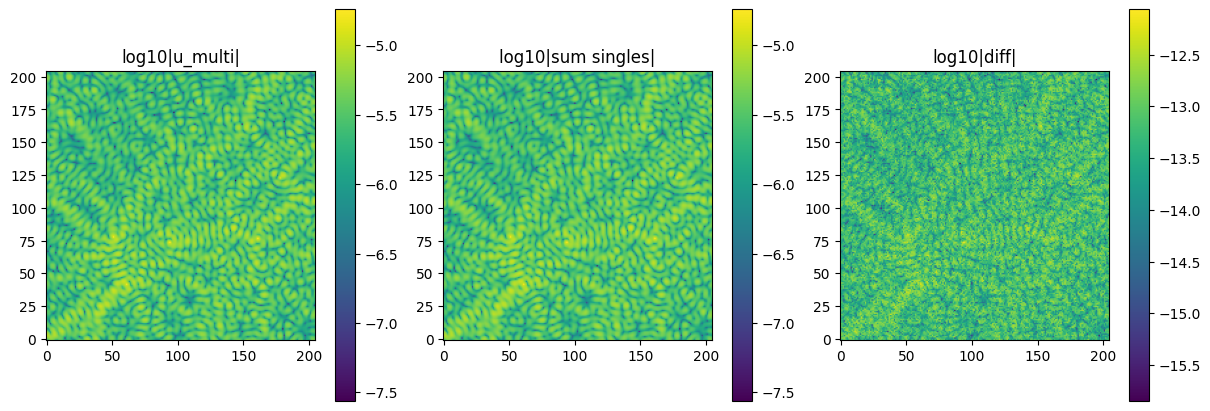

In [27]:
import json, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT_ROOT = Path("data/D_outercollar_rand1to5_200_20_20")
TRAIN_DIR = OUT_ROOT / "train"

# pick a multi-source sample (prefer ns>=3)
fp = None
for cand in sorted(TRAIN_DIR.glob("*.npz"))[:200]:
    z = np.load(cand, allow_pickle=True)
    meta = json.loads(z["meta_json"][0])
    if len(meta["sources"]) >= 3:
        fp = cand
        break

assert fp is not None, "Could not find a multi-source sample to test."
print("Testing superposition on:", fp.name)

z = np.load(fp, allow_pickle=True)
u_multi = z["u_real"] + 1j*z["u_imag"]
meta = json.loads(z["meta_json"][0])

omega = float(meta["omega"])
sources = meta["sources"]

# re-solve each source individually and sum
u_sum = np.zeros_like(u_multi, dtype=np.complex128)
for s in sources:
    _, u1, _ = solve_one_sample(omega=omega, ppw=PPW, sources=[s], case_name=meta["case"])
    u_sum += u1

diff = u_multi - u_sum
rel = np.linalg.norm(diff) / (np.linalg.norm(u_multi) + 1e-30)
print("Relative superposition error:", rel)

# visualize in log-scale
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
im = axs[0].imshow(np.log10(np.abs(u_multi).T + 1e-16), origin="lower"); axs[0].set_title("log10|u_multi|"); plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.log10(np.abs(u_sum).T + 1e-16), origin="lower"); axs[1].set_title("log10|sum singles|"); plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(np.log10(np.abs(diff).T + 1e-16), origin="lower"); axs[2].set_title("log10|diff|"); plt.colorbar(im, ax=axs[2])
plt.show()


## Check 4 — Distribution checks: nsources + omega + amplitude scales

This tells you whether your dataset is balanced and not exploding.

In [28]:
import json, numpy as np
from pathlib import Path
from collections import Counter

OUT_ROOT = Path("data/D_outercollar_rand1to5_200_20_20")
manifest = OUT_ROOT / "manifest_train.jsonl"

rows = []
with manifest.open("r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

ns_counts = Counter()
omega_counts = Counter()
u_norms = []
u_max = []
f_norms = []
solve_times = []
res_rel = []

for row in rows:
    z = np.load(Path(row["file"]), allow_pickle=True)
    meta = json.loads(z["meta_json"][0])
    ns = len(meta["sources"])
    ns_counts[ns] += 1
    omega_counts[float(meta["omega"])] += 1

    u = z["u_real"] + 1j*z["u_imag"]
    f = z["f_real"] + 1j*z["f_imag"]

    u_norms.append(float(np.linalg.norm(u)))
    u_max.append(float(np.max(np.abs(u))))
    f_norms.append(float(np.linalg.norm(f)))
    solve_times.append(float(meta["solve_time_sec"]))
    res_rel.append(float(meta["res_rel"]))

print("nsources distribution:", dict(ns_counts))
print("omega distribution:", dict(omega_counts))

def stats(a):
    a = np.asarray(a)
    return {"min": float(a.min()), "p50": float(np.median(a)), "p90": float(np.quantile(a, 0.9)), "max": float(a.max())}

print("||f|| stats:", stats(f_norms))
print("||u|| stats:", stats(u_norms))
print("max|u| stats:", stats(u_max))
print("solve_time_sec stats:", stats(solve_times))
print("res_rel stats:", stats(res_rel))


nsources distribution: {5: 41, 4: 47, 2: 52, 1: 36, 3: 24}
omega distribution: {128.0: 68, 64.0: 70, 32.0: 62}
||f|| stats: {'min': 1.030729055404663, 'p50': 2.641615152359009, 'p90': 3.4563769102096558, 'max': 4.014459133148193}
||u|| stats: {'min': 0.0002491450577508658, 'p50': 0.0007899256888777018, 'p90': 0.001420714845880866, 'max': 0.00210018502548337}
max|u| stats: {'min': 1.1837848433060572e-05, 'p50': 2.2513391741085798e-05, 'p90': 2.945583419204922e-05, 'max': 3.936942448490299e-05}
solve_time_sec stats: {'min': 7.48827380000148, 'p50': 9.891390099975979, 'p90': 10.970176430017455, 'max': 11.723748599993996}
res_rel stats: {'min': 1.6959821212647837e-14, 'p50': 3.122544743551683e-14, 'p90': 8.399484115138764e-14, 'max': 1.3368209085234306e-13}
